In [1]:
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

REG_DIR = Path("../datasets/battery_alt_dataset/regular_alt_batteries")
MAX_FILES = 5
DOWNSAMPLE_STEP = 20
ROLLING_WINDOW = 10
MAX_ALT_ROWS = 100_000

USE_DISCHARGE_ONLY = True  # True = only discharge phase, False = all modes

### Load Zenodo `final_df.csv`

In [2]:
final_path = Path("../datasets/preprocessed/final_df.csv")
zenodo_df = pd.read_csv(final_path)

zen_rul_max = zenodo_df["rul"].max()
print("Zenodo RUL max =", zen_rul_max)

# Train/test split by battery_id
battery_ids = zenodo_df["battery_id"].unique()
train_ids, test_ids = train_test_split(battery_ids, test_size=0.2, random_state=42)

train_df = zenodo_df[zenodo_df["battery_id"].isin(train_ids)].copy()
test_df  = zenodo_df[zenodo_df["battery_id"].isin(test_ids)].copy()

drop_cols = ["battery_id", "cycle_index", "rul", "time"]
feature_cols = [c for c in zenodo_df.columns if c not in drop_cols]
print("feature from Zenodo:", len(feature_cols))

display(zenodo_df.head())

Zenodo RUL max = 1299
feature from Zenodo: 39


,battery_id,cycle_index,protocol_id,discharge_capacity_ah_max,discharge_capacity_ah_mean,discharge_capacity_ah_min,charge_capacity_ah_max,charge_capacity_ah_mean,charge_capacity_ah_min,voltage_v_max,...,rolling_mean_soh_percent,rolling_std_discharge_capacity_ah_max,rolling_std_charge_capacity_ah_max,rolling_std_voltage_v_max,rolling_std_current_a_mean,rolling_std_discharge_energy_wh_max,rolling_std_charge_energy_wh_max,rolling_std_aux_temperature_1_c_mean,rolling_std_current_a_abs_mean,rolling_std_soh_percent
0,1,1,1,2.421769,0.849490,3.200319e-05,2.394174,2.115371,0.003330,4.200036,...,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,2,1,2.400751,0.442225,2.473989e-10,2.416324,1.819254,0.003330,4.200032,...,99.566061,0.014862,0.015662,0.000003,0.003854,0.228743,0.055605,0.524013,0.435901,0.613682
2,1,3,1,2.399412,0.442961,2.987066e-05,2.396731,1.805943,0.003330,4.200024,...,99.402985,0.012539,0.012118,0.000006,0.002735,0.187687,0.043485,0.444561,0.355911,0.517769
3,1,4,1,2.397874,0.443705,3.193769e-05,2.394747,1.803746,0.003329,4.200034,...,99.305570,0.011273,0.010610,0.000005,0.002262,0.163473,0.038482,0.387616,0.308554,0.465491
4,1,5,1,2.397038,0.443911,3.313753e-05,2.393583,1.802770,0.003329,4.200028,...,99.240217,0.010384,0.009694,0.000005,0.001984,0.146851,0.035502,0.347763,0.276177,0.428797


### Load NASA dataset (Regular-alt) + basic processing

In [3]:
if not REG_DIR.exists():
    raise FileNotFoundError(f"NASA folder not found: {REG_DIR.resolve()}")

csv_files = sorted(REG_DIR.glob("battery*.csv"))
if not csv_files:
    raise FileNotFoundError(f"No battery*.csv files found in {REG_DIR.resolve()}")

csv_files = csv_files[:MAX_FILES]
print(f"\nLoading {len(csv_files)} NASA files:")
for f in csv_files:
    print(" -", f.name)

usecols = ["time", "mode", "voltage_load", "current_load", "temperature_battery"]

dfs = []
for b_id, f in enumerate(csv_files, start=1):
    tmp = pd.read_csv(f, usecols=usecols, low_memory=False)
    tmp["battery_id_alt"] = b_id
    dfs.append(tmp)

alt_raw = pd.concat(dfs, ignore_index=True)
print("\nCombined NASA shape before processing:", alt_raw.shape)

for c in ["time", "mode", "voltage_load", "current_load", "temperature_battery"]:
    if c in alt_raw.columns:
        alt_raw[c] = pd.to_numeric(alt_raw[c], errors="coerce")

# Downsample per battery
alt_raw = (alt_raw.groupby("battery_id_alt", group_keys=False).apply(lambda x: x.sort_values("time").iloc[::DOWNSAMPLE_STEP]).reset_index(drop=True))
print("NASA shape after downsampling:", alt_raw.shape)

# Select operating phases by mode
# mode: -1 = discharge, 0 = rest, 1 = charge
if "mode" in alt_raw.columns:
    alt_raw["mode"] = pd.to_numeric(alt_raw["mode"], errors="coerce")

if USE_DISCHARGE_ONLY:
    alt_raw = alt_raw[alt_raw["mode"] == -1].copy()
    print("Using discharge phase only (mode = -1). Shape:", alt_raw.shape)
else:
    mode_map = {-1: "discharge", 0: "rest", 1: "charge"}
    alt_raw["mode_flag"] = alt_raw["mode"].map(mode_map)
    alt_raw["mode_flag"] = alt_raw["mode_flag"].astype("category")
    print("Using all modes with categorical mode_flag. Value counts:")
    print(alt_raw["mode_flag"].value_counts())

    if "mode_flag" not in train_df.columns:
        train_df["mode_flag"] = "discharge"
        test_df["mode_flag"]  = "discharge"


Loading 5 NASA files:
 - battery00.csv
 - battery01.csv
 - battery10.csv
 - battery11.csv
 - battery20.csv

Combined NASA shape before processing: (12049033, 6)
NASA shape after downsampling: (602455, 6)
Using discharge phase only (mode = -1). Shape: (86191, 6)


### Compute RUL for NASA + rolling features + align structure

In [4]:
# Compute RUL for Regular-alt and rescale to match Zenodo
alt_raw = alt_raw.sort_values(["battery_id_alt", "time"]).reset_index(drop=True)

alt_raw["rul_raw"] = 0.0
for bid, sub in alt_raw.groupby("battery_id_alt"):
    t_end = sub["time"].max()
    alt_raw.loc[sub.index, "rul_raw"] = t_end - sub["time"]

raw_max = alt_raw["rul_raw"].max()
alt_raw["rul"] = alt_raw["rul_raw"] / raw_max * zen_rul_max

print("NASA RUL_raw max:", raw_max)
print("NASA RUL max after rescale:", alt_raw["rul"].max())
print(alt_raw.shape)
print(alt_raw.columns.tolist())

# Map column names
rename_map = {"voltage_load": "voltage_v_mean","current_load": "current_a_mean","temperature_battery": "aux_temperature_1_c_mean"}
alt_raw = alt_raw.rename(columns=rename_map, errors="ignore")

if "current_a_mean" in alt_raw.columns:
    alt_raw["current_a_abs_mean"] = alt_raw["current_a_mean"].abs()

window = ROLLING_WINDOW
bases = ["voltage_v_mean","current_a_mean","aux_temperature_1_c_mean","current_a_abs_mean"]
parts = []
for bid, sub in alt_raw.groupby("battery_id_alt", sort=False):
    sub = sub.sort_values("time").copy()
    for base in bases:
        if base not in sub.columns:
            continue
        sub[f"rolling_mean_{base}"] = (sub[base].shift(1).rolling(window, min_periods=1).mean())
        sub[f"rolling_std_{base}"] = (sub[base].shift(1).rolling(window, min_periods=1).std())
    parts.append(sub)

alt_raw = pd.concat(parts, ignore_index=True)
print("NASA shape after adding rolling features:", alt_raw.shape)
print(alt_raw.columns.tolist())

alt_aligned = alt_raw.copy()
alt_aligned["battery_id"] = alt_aligned["battery_id_alt"]

keep_cols = ["battery_id", "time", "rul"]
for c in ["voltage_v_mean",
            "current_a_mean",
            "aux_temperature_1_c_mean",
            "current_a_abs_mean",]:
    if c in alt_aligned.columns:
        keep_cols.append(c)

keep_cols += [c for c in alt_aligned.columns if c.startswith("rolling_mean_") or c.startswith("rolling_std_")]

if "mode_flag" in alt_aligned.columns:
    keep_cols.append("mode_flag")

alt_aligned = alt_aligned[keep_cols].reset_index(drop=True)
print("NASA aligned shape:", alt_aligned.shape)

if len(alt_aligned) > MAX_ALT_ROWS:
    alt_aligned = alt_aligned.sample(n=MAX_ALT_ROWS, random_state=42).reset_index(drop=True)
    print("Aligned NASA shape after sampling:", alt_aligned.shape)

NASA RUL_raw max: 4916734.167
NASA RUL max after rescale: 1299.0
(86191, 8)
['time', 'mode', 'temperature_battery', 'voltage_load', 'current_load', 'battery_id_alt', 'rul_raw', 'rul']
NASA shape after adding rolling features: (86191, 17)
['time', 'mode', 'aux_temperature_1_c_mean', 'voltage_v_mean', 'current_a_mean', 'battery_id_alt', 'rul_raw', 'rul', 'current_a_abs_mean', 'rolling_mean_voltage_v_mean', 'rolling_std_voltage_v_mean', 'rolling_mean_current_a_mean', 'rolling_std_current_a_mean', 'rolling_mean_aux_temperature_1_c_mean', 'rolling_std_aux_temperature_1_c_mean', 'rolling_mean_current_a_abs_mean', 'rolling_std_current_a_abs_mean']
NASA aligned shape: (86191, 15)


### Common features + base matrices (Zenodo & NASA)

In [5]:
common_features = [f for f in feature_cols if f in alt_aligned.columns]
print("\nNumber of common features (Zenodo ∩ NASA):", len(common_features))

if "mode_flag" in alt_aligned.columns and "mode_flag" not in train_df.columns:
    train_df["mode_flag"] = "discharge"
    test_df["mode_flag"]  = "discharge"

# Zenodo
X_train_base = train_df[common_features].copy()
X_test       = test_df[common_features].copy()
y_train_base = train_df["rul"].values
y_test       = test_df["rul"].values

# NASA full
X_alt_full = alt_aligned[common_features].copy()
y_alt_full = alt_aligned["rul"].values

print("Zenodo train:", X_train_base.shape,"| Zenodo test:", X_test.shape,"| NASA full:", X_alt_full.shape)


Number of common features (Zenodo ∩ NASA): 10
Zenodo train: (39923, 10) | Zenodo test: (9258, 10) | NASA full: (86191, 10)


### Preprocessing and Random Forest pipeline

In [6]:
def build_rf_global():
    numeric_features = X_train_base.select_dtypes(include=["int64", "float64"]).columns
    categorical_features = X_train_base.select_dtypes(include=["object", "category"]).columns

    numeric_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="mean")),("scaler", StandardScaler())])
    categorical_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="most_frequent")),("encoder", OneHotEncoder(handle_unknown="ignore"))])

    transformers = []
    if len(numeric_features) > 0:
        transformers.append(("num", numeric_transformer, numeric_features))
    if len(categorical_features) > 0:
        transformers.append(("cat", categorical_transformer, categorical_features))

    preprocess = ColumnTransformer(transformers=transformers)
    rf = RandomForestRegressor(
        n_estimators=500,
        max_depth=16,
        min_samples_split=4,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1,)

    model = Pipeline(steps=[("preprocess", preprocess), ("rf", rf)])
    return model

### Baseline (Zenodo only → Zenodo & NASA)

In [7]:
model_base = build_rf_global()
model_base.fit(X_train_base, y_train_base)

# Zenodo test
y_pred_zen_base = model_base.predict(X_test)
r2_zen_base   = r2_score(y_test, y_pred_zen_base)
rmse_zen_base = mean_squared_error(y_test, y_pred_zen_base) ** 0.5
mae_zen_base  = mean_absolute_error(y_test, y_pred_zen_base)

# NASA cross-dataset: use full NASA
y_pred_alt_base = model_base.predict(X_alt_full)
r2_alt_base   = r2_score(y_alt_full, y_pred_alt_base)
rmse_alt_base = mean_squared_error(y_alt_full, y_pred_alt_base) ** 0.5
mae_alt_base  = mean_absolute_error(y_alt_full, y_pred_alt_base)

print("=== BASELINE RF (Train: Zenodo → Test: Zenodo) ===")
print(f"R²   : {r2_zen_base:.4f}")
print(f"RMSE : {rmse_zen_base:.2f}")
print(f"MAE  : {mae_zen_base:.2f}")

print("\n=== BASELINE RF Cross-Dataset (Train: Zenodo → Test: NASA full) ===")
print(f"R²   : {r2_alt_base:.4f}")
print(f"RMSE : {rmse_alt_base:.2f}")
print(f"MAE  : {mae_alt_base:.2f}")

=== BASELINE RF (Train: Zenodo → Test: Zenodo) ===
R²   : 0.8162
RMSE : 180.12
MAE  : 106.97

=== BASELINE RF Cross-Dataset (Train: Zenodo → Test: NASA full) ===
R²   : -4.5587
RMSE : 930.38
MAE  : 774.96


### Fine-tune 5% / 10% / 15% NASA

In [8]:
ratios = [5, 10, 15]
metrics = []

model_ft_5 = None
model_ft_10 = None
model_ft_15 = None

X_alt_test_5 = y_alt_test_5 = None
X_alt_test_10 = y_alt_test_10 = None
X_alt_test_15 = y_alt_test_15 = None

for ratio in ratios:
    frac = ratio / 100.0
    alt_fine = alt_aligned.sample(frac=frac, random_state=42)
    alt_test = alt_aligned.drop(alt_fine.index)

    X_alt_fine = alt_fine[common_features].copy()
    y_alt_fine = alt_fine["rul"].values

    X_alt_test = alt_test[common_features].copy()
    y_alt_test = alt_test["rul"].values

    X_finetune = pd.concat([X_train_base, X_alt_fine], axis=0)
    y_finetune = np.concatenate([y_train_base, y_alt_fine])

    model_ft = build_rf_global()
    model_ft.fit(X_finetune, y_finetune)

    if ratio == 5:
        model_ft_5 = model_ft
        X_alt_fine_5 = X_alt_fine    
        y_alt_fine_5 = y_alt_fine    
        X_alt_test_5 = X_alt_test
        y_alt_test_5 = y_alt_test
    elif ratio == 10:
        model_ft_10 = model_ft
        X_alt_fine_10 = X_alt_fine   
        y_alt_fine_10 = y_alt_fine 
        X_alt_test_10 = X_alt_test
        y_alt_test_10 = y_alt_test
    elif ratio == 15:
        model_ft_15 = model_ft
        X_alt_fine_15 = X_alt_fine   
        y_alt_fine_15 = y_alt_fine  
        X_alt_test_15 = X_alt_test
        y_alt_test_15 = y_alt_test


    # Evaluate on Zenodo test
    y_pred_zen = model_ft.predict(X_test)
    r2_zen   = r2_score(y_test, y_pred_zen)
    rmse_zen = mean_squared_error(y_test, y_pred_zen) ** 0.5
    mae_zen  = mean_absolute_error(y_test, y_pred_zen)

    # Evaluate on NASA test (cross-dataset)
    y_pred_alt = model_ft.predict(X_alt_test)
    r2_alt   = r2_score(y_alt_test, y_pred_alt)
    rmse_alt = mean_squared_error(y_alt_test, y_pred_alt) ** 0.5
    mae_alt  = mean_absolute_error(y_alt_test, y_pred_alt)

    print(f"\n=== FINE-TUNED RF ({ratio}% NASA) ===")
    print(">>> Test on Zenodo")
    print(f"R²   : {r2_zen:.4f}")
    print(f"RMSE : {rmse_zen:.2f}")
    print(f"MAE  : {mae_zen:.2f}")

    print("\n>>> Test on NASA")
    print(f"R²   : {r2_alt:.4f}")
    print(f"RMSE : {rmse_alt:.2f}")
    print(f"MAE  : {mae_alt:.2f}")

    metrics.append({
        "Fine-tune (%)": ratio,
        "R2 (Zenodo)": r2_zen,
        "RMSE (Zenodo)": rmse_zen,
        "MAE (Zenodo)": mae_zen,
        "R2 (NASA)": r2_alt,
        "RMSE (NASA)": rmse_alt,
        "MAE (NASA)": mae_alt})

metrics_df = pd.DataFrame(metrics)
display(metrics_df)


=== FINE-TUNED RF (5% NASA) ===
>>> Test on Zenodo
R²   : 0.7858
RMSE : 194.45
MAE  : 112.53

>>> Test on NASA
R²   : 0.9222
RMSE : 110.06
MAE  : 63.18

=== FINE-TUNED RF (10% NASA) ===
>>> Test on Zenodo
R²   : 0.7984
RMSE : 188.65
MAE  : 110.96

>>> Test on NASA
R²   : 0.9342
RMSE : 101.26
MAE  : 57.25

=== FINE-TUNED RF (15% NASA) ===
>>> Test on Zenodo
R²   : 0.8250
RMSE : 175.75
MAE  : 104.51

>>> Test on NASA
R²   : 0.9414
RMSE : 95.58
MAE  : 53.26


,Fine-tune (%),R2 (Zenodo),RMSE (Zenodo),MAE (Zenodo),R2 (NASA),RMSE (NASA),MAE (NASA)
0,5,0.785760,194.448924,112.532075,0.922225,110.062731,63.183230
1,10,0.798355,188.646646,110.957732,0.934152,101.264882,57.249950
2,15,0.824979,175.751940,104.512794,0.941353,95.576182,53.260339


### Visualization

> #### 1. Distribution Comparison (Zenodo vs NASA)

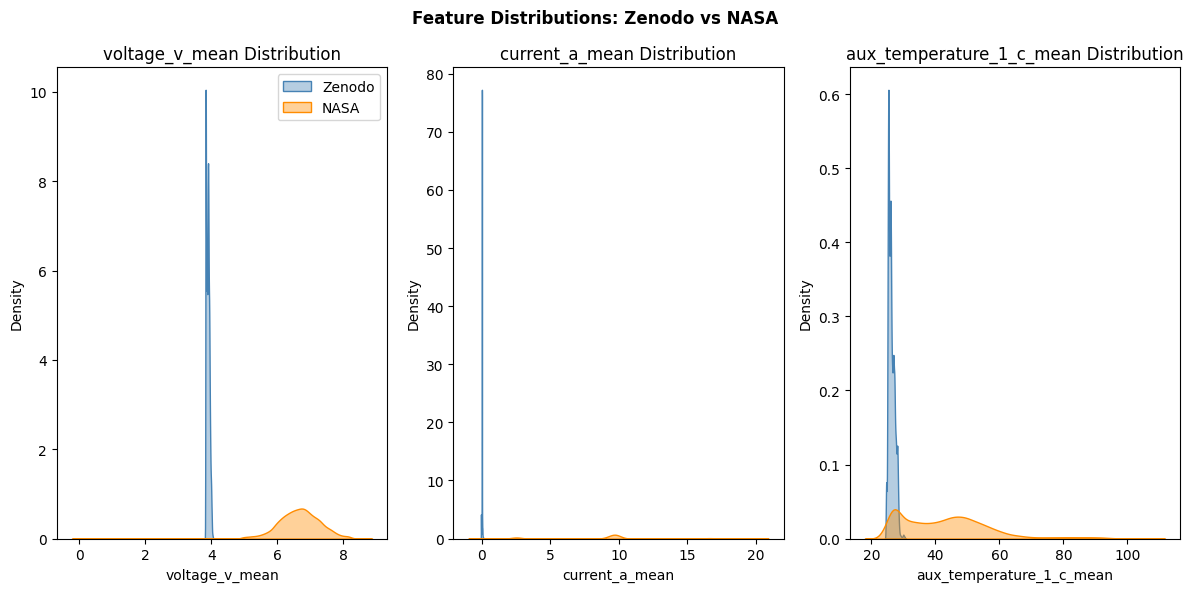

In [9]:
plt.figure(figsize=(12, 6))
selected_feats = ["voltage_v_mean", "current_a_mean", "aux_temperature_1_c_mean"]

for i, feat in enumerate(selected_feats, 1):
    plt.subplot(1, 3, i)
    sns.kdeplot(train_df[feat], label="Zenodo", color="steelblue", fill=True, alpha=0.4)
    sns.kdeplot(alt_aligned[feat], label="NASA", color="darkorange", fill=True, alpha=0.4)
    plt.title(f"{feat} Distribution")
    plt.xlabel(feat)
    plt.ylabel("Density")
    if i == 1:
        plt.legend()

plt.suptitle("Feature Distributions: Zenodo vs NASA", weight="bold")
plt.tight_layout()
plt.show()

> #### 2. Sensitivity plot: R² / RMSE / MAE vs % NASA

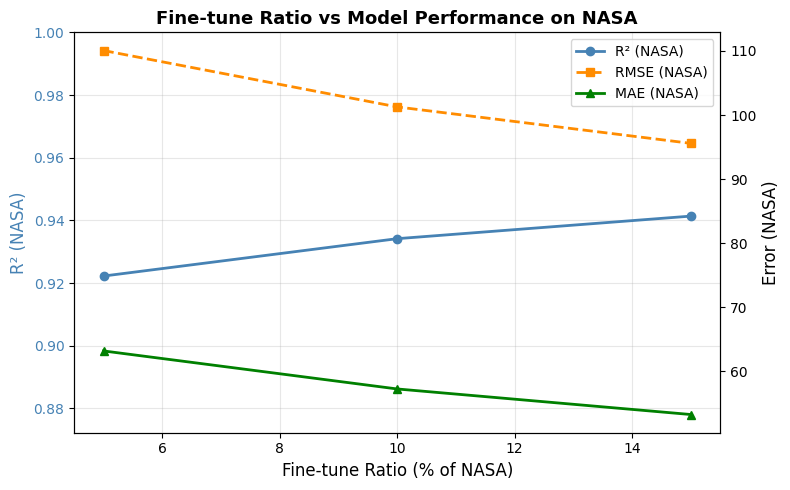

In [10]:
metrics_df["Fine-tune (%)"] = metrics_df["Fine-tune (%)"].astype(float)

x         = metrics_df.iloc[:, 0].values
r2_nasa   = metrics_df["R2 (NASA)"].values
rmse_nasa = metrics_df["RMSE (NASA)"].values
mae_nasa  = metrics_df["MAE (NASA)"].values

fig, ax1 = plt.subplots(figsize=(8, 5))

ax1.plot(x, r2_nasa, "o-", color="steelblue", linewidth=2, label="R² (NASA)")
ax1.set_xlabel("Fine-tune Ratio (% of NASA)", fontsize=12)
ax1.set_ylabel("R² (NASA)", color="steelblue", fontsize=12)
ax1.tick_params(axis="y", labelcolor="steelblue")
ax1.set_ylim(r2_nasa.min() - 0.05, 1.0)
ax1.grid(alpha=0.3)

ax2 = ax1.twinx()
ax2.plot(x, rmse_nasa, "s--", color="darkorange", linewidth=2, label="RMSE (NASA)")
ax2.plot(x, mae_nasa, "^-", color="green", linewidth=2, label="MAE (NASA)")
ax2.set_ylabel("Error (NASA)", fontsize=12, color="black")
ax2.tick_params(axis="y", labelcolor="black")

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc="upper right")

plt.title("Fine-tune Ratio vs Model Performance on NASA", weight="bold", fontsize=13)
plt.tight_layout()
plt.show()

> #### 3. True vs Predicted scatter (Baseline vs Fine-tuned 15%)

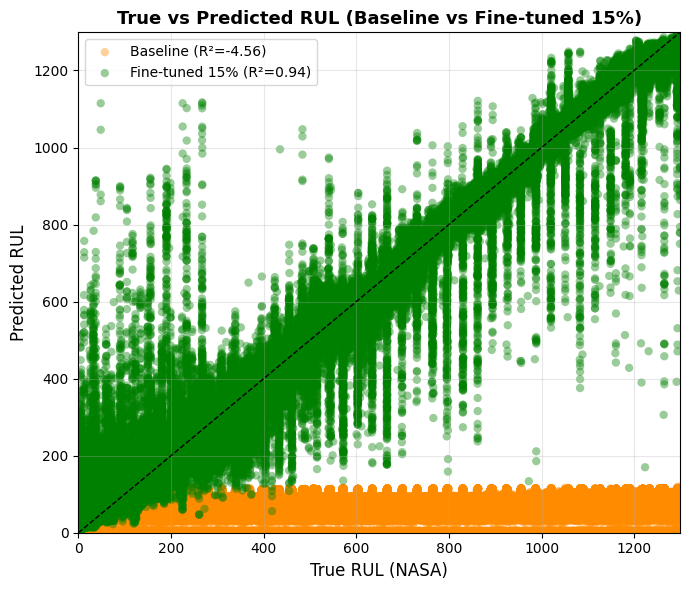

In [11]:
y_pred_alt_base_15 = model_base.predict(X_alt_test_15)
y_pred_alt_ft_15   = model_ft_15.predict(X_alt_test_15)

r2_base = r2_score(y_alt_test_15, y_pred_alt_base_15)
r2_ft15 = r2_score(y_alt_test_15, y_pred_alt_ft_15)

plt.figure(figsize=(7, 6))
plt.scatter(y_alt_test_15,y_pred_alt_base_15,alpha=0.4,label=f"Baseline (R²={r2_base:.2f})",color="darkorange",edgecolor="none",)
plt.scatter(y_alt_test_15,y_pred_alt_ft_15,alpha=0.4,label=f"Fine-tuned 15% (R²={r2_ft15:.2f})",color="green",edgecolor="none",)

lims = [min(y_alt_test_15.min(), 0), y_alt_test_15.max()]
plt.plot(lims, lims, "k--", lw=1)
plt.xlim(lims)
plt.ylim(lims)

plt.xlabel("True RUL (NASA)", fontsize=12)
plt.ylabel("Predicted RUL", fontsize=12)
plt.title("True vs Predicted RUL (Baseline vs Fine-tuned 15%)", fontsize=13, weight="bold")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

> #### 4. RUL Trend (Baseline vs Fine-tuned 15%)

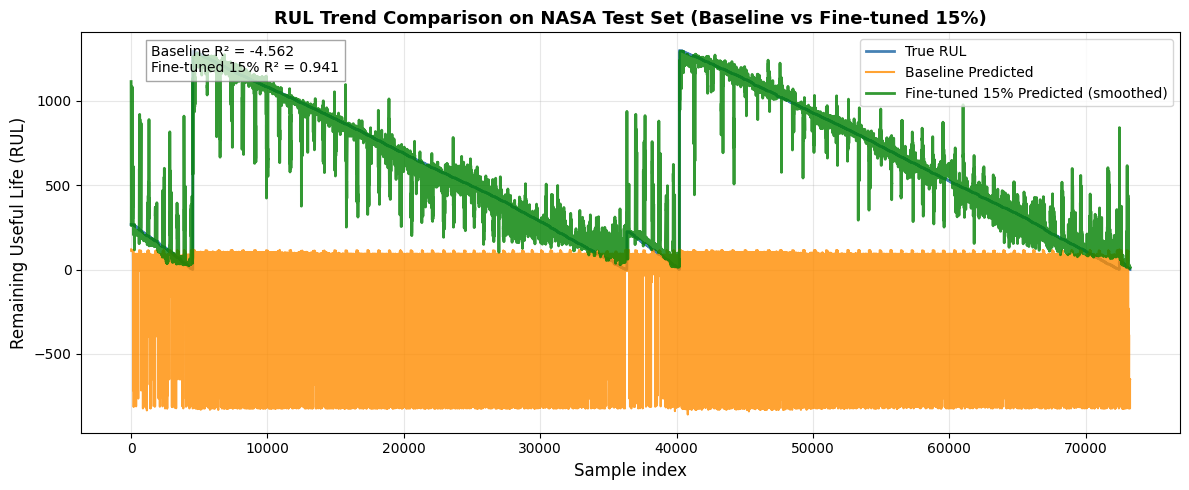

In [12]:
y_pred_alt_base_15 = model_base.predict(X_alt_test_15)
y_pred_alt_ft_15   = model_ft_15.predict(X_alt_test_15)

r2_base = r2_score(y_alt_test_15, y_pred_alt_base_15)
r2_ft15 = r2_score(y_alt_test_15, y_pred_alt_ft_15)

plt.figure(figsize=(12, 5))

plt.plot(y_alt_test_15, label="True RUL", color="steelblue", linewidth=2)
plt.plot(y_pred_alt_base_15, label="Baseline Predicted", color="darkorange", alpha=0.8)
plt.plot(pd.Series(y_pred_alt_ft_15).rolling(5, min_periods=1).mean(),label="Fine-tuned 15% Predicted (smoothed)",
    color="green",linewidth=2,alpha=0.8,)

plt.xlabel("Sample index", fontsize=12)
plt.ylabel("Remaining Useful Life (RUL)", fontsize=12)
plt.title("RUL Trend Comparison on NASA Test Set (Baseline vs Fine-tuned 15%)",fontsize=13, weight="bold")
plt.legend()
plt.grid(alpha=0.3)
plt.text(0.02 * len(y_alt_test_15),max(y_alt_test_15) * 0.9,
    f"Baseline R² = {r2_base:.3f}\nFine-tuned 15% R² = {r2_ft15:.3f}",
    bbox=dict(facecolor="white", alpha=0.7, edgecolor="gray"),)
plt.tight_layout()
plt.show()

> #### 5. RUL Trend (Fine-tune 5%, 10%, 15%)


=== Fine-tuning with 5% NASA data ===

=== Fine-tuning with 10% NASA data ===

=== Fine-tuning with 15% NASA data ===


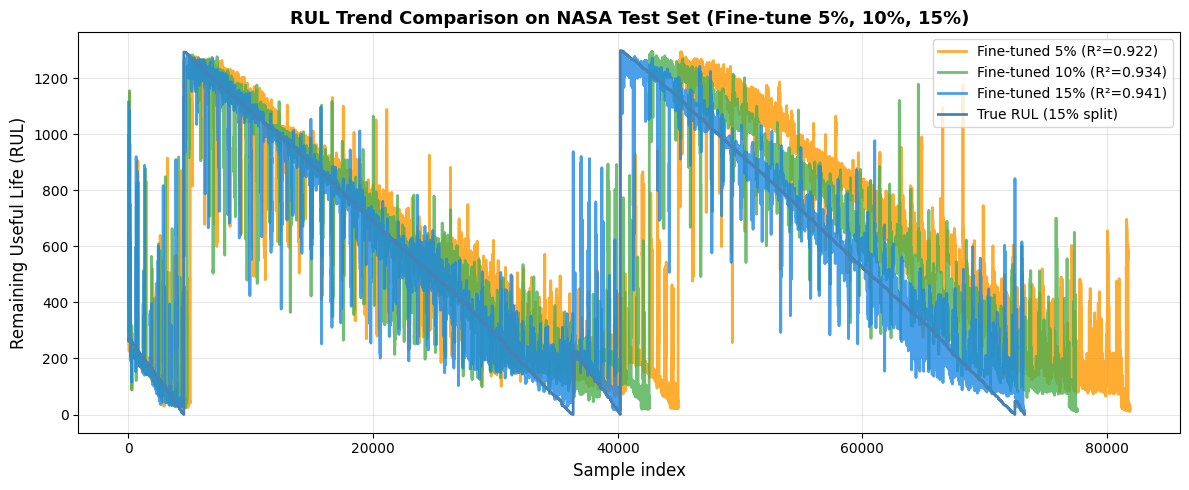

In [13]:
fine_tune_ratios = [0.05, 0.10, 0.15]
preds, r2_scores = {}, {}

for ratio in fine_tune_ratios:
    print(f"\n=== Fine-tuning with {ratio*100:.0f}% NASA data ===")
    alt_fine = alt_aligned.sample(frac=ratio, random_state=42)
    alt_test = alt_aligned.drop(alt_fine.index)

    X_alt_fine = alt_fine[common_features].copy()
    y_alt_fine = alt_fine["rul"].values
    X_alt_test = alt_test[common_features].copy()
    y_alt_test = alt_test["rul"].values

    X_finetune = pd.concat([X_train_base, X_alt_fine], axis=0)
    y_finetune = np.concatenate([y_train_base, y_alt_fine])

    model_ft = build_rf_global()
    model_ft.fit(X_finetune, y_finetune)

    y_pred = model_ft.predict(X_alt_test)
    r2 = r2_score(y_alt_test, y_pred)

    preds[f"{int(ratio*100)}%"] = (y_alt_test, y_pred)
    r2_scores[f"{int(ratio*100)}%"] = r2

plt.figure(figsize=(12, 5))
for color, ratio in zip(["#FF9800", "#4CAF50", "#1E88E5"], ["5%", "10%", "15%"]):
    y_true, y_pred = preds[ratio]
    plt.plot(pd.Series(y_pred).rolling(5, min_periods=1).mean(),label=f"Fine-tuned {ratio} (R²={r2_scores[ratio]:.3f})",
        color=color,linewidth=2,alpha=0.8,)

plt.plot(preds["15%"][0], label="True RUL (15% split)", color="steelblue", linewidth=2)
plt.xlabel("Sample index", fontsize=12)
plt.ylabel("Remaining Useful Life (RUL)", fontsize=12)
plt.title("RUL Trend Comparison on NASA Test Set (Fine-tune 5%, 10%, 15%)",fontsize=13, weight="bold")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

> #### 6. Check Overfitting (Fine-tune 15%)

In [14]:
y_pred_zen_15 = model_ft_15.predict(X_test)
r2_zen_15   = r2_score(y_test, y_pred_zen_15)
rmse_zen_15 = mean_squared_error(y_test, y_pred_zen_15) ** 0.5
mae_zen_15  = mean_absolute_error(y_test, y_pred_zen_15)

print("=== Zenodo test (Fine-tuned 15%) ===")
print(f"R²   : {r2_zen_15:.3f}")
print(f"RMSE : {rmse_zen_15:.1f}")
print(f"MAE  : {mae_zen_15:.1f}")

y_pred_nasa_train_15 = model_ft_15.predict(X_alt_fine_15)
r2_nasa_train_15   = r2_score(y_alt_fine_15, y_pred_nasa_train_15)
rmse_nasa_train_15 = mean_squared_error(y_alt_fine_15, y_pred_nasa_train_15) ** 0.5
mae_nasa_train_15  = mean_absolute_error(y_alt_fine_15, y_pred_nasa_train_15)

print("\n=== NASA train (Fine-tune 15%) ===")
print(f"R²   : {r2_nasa_train_15:.3f}")
print(f"RMSE : {rmse_nasa_train_15:.1f}")
print(f"MAE  : {mae_nasa_train_15:.1f}")

y_pred_nasa_test_15 = model_ft_15.predict(X_alt_test_15)
r2_nasa_test_15   = r2_score(y_alt_test_15, y_pred_nasa_test_15)
rmse_nasa_test_15 = mean_squared_error(y_alt_test_15, y_pred_nasa_test_15) ** 0.5
mae_nasa_test_15  = mean_absolute_error(y_alt_test_15, y_pred_nasa_test_15)

print("\n=== NASA test (Fine-tune 15%) ===")
print(f"R²   : {r2_nasa_test_15:.3f}")
print(f"RMSE : {rmse_nasa_test_15:.1f}")
print(f"MAE  : {mae_nasa_test_15:.1f}")

=== Zenodo test (Fine-tuned 15%) ===
R²   : 0.825
RMSE : 175.8
MAE  : 104.5

=== NASA train (Fine-tune 15%) ===
R²   : 0.983
RMSE : 51.7
MAE  : 29.0

=== NASA test (Fine-tune 15%) ===
R²   : 0.941
RMSE : 95.6
MAE  : 53.3


## Summary of Cross-Dataset Fine-tuning Experiment (Zenodo → NASA)

### 1. Technical Findings

- **Baseline (Train: Zenodo → Test: NASA)**  
  - The Random Forest model trained solely on Zenodo performed very poorly when tested on NASA data.  
  - **R² ≈ -4.56**, indicating negative generalization and a complete failure to capture the target trend.  
  - This is caused by **distribution shift** — input features such as voltage, current, and temperature follow very different statistical patterns between the two datasets.

- **Fine-tuning with partial NASA data**
  - Fine-tuning was performed by combining Zenodo data with subsets of NASA data (5%, 10%, 15%).
  - Results on the NASA test set:
    - **5% NASA:** R² ≈ **0.92**
    - **10% NASA:** R² ≈ **0.93**
    - **15% NASA:** R² ≈ **0.94**
  - Even a small portion of NASA data enables the model to adapt to the new domain, learning the degradation trend of NASA batteries effectively.

- **Behavioral analysis from plots**
  - **Baseline RUL trend:** The predicted RUL (orange) deviates heavily from the true RUL, consistently underestimating battery life.  
  - **Fine-tuned 15% RUL trend:** The green line (after smoothing) follows the true RUL pattern closely across all cycles.  
  - **Scatter Plot (True vs. Predicted):**  
    - Baseline predictions scatter far from the diagonal line and even cluster in negative ranges.  
    - Fine-tuned predictions align tightly along the y=x diagonal — strong indication of successful domain adaptation.

- **Technical Conclusion:**  
  Fine-tuning with only **10–15% of the new dataset (NASA)** transformed the model from complete failure (R² < 0) to a highly accurate predictor (R² ≈ 0.94).  
  This confirms the effectiveness of **cross-domain transfer learning** — improving model adaptability without retraining from scratch.

---

### 2. Business Impact

- **Reduced data collection and labeling cost**
  - Only 5–15% of new data is needed for fine-tuning, eliminating the need to re-collect or label entire datasets.
  - This yields a potential **80–90% reduction in data acquisition and labeling cost** for new production environments.

- **Improved prediction reliability**
  - Increasing R² from -4.56 → 0.94 drastically reduces prediction error.  
  - Enables confident use of the model for:
    - **Predictive maintenance**
    - **Battery replacement scheduling**
    - **Downtime risk reduction**

- **Model reusability across factories and clients**
  - A model trained on Zenodo (one lab or factory) can be adapted to NASA (a different environment) using small-scale fine-tuning.
  - This concept supports:
    - Different production lines
    - Different OEM clients
    - Different battery packs with similar sensors  
  - Result: faster deployment of predictive models across multiple domains with minimal retraining.

- **Strategic data-driven scalability**
  - Demonstrates that early investment in a base model can be leveraged across future datasets or new clients.  
  - Provides a foundation for a **Battery Health Analytics Platform**, where models can be quickly personalized for each customer via fine-tuning.